In [1]:
import torch
import torch.nn as nn
import math
import torchvision.transforms as transforms
import numpy as np
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as tF
import torchvision.transforms.functional as tvF

import random
import torch.utils.model_zoo as model_zoo
import torch.backends.cudnn as cudnn
from easydict import EasyDict
import logging
from torch.utils.data import Dataset, DataLoader
import glob
import os
from skimage import io, transform
import matplotlib.pyplot as plt
import PIL
import time
from collections import Counter
import gc
from unet import UNet

In [2]:
PIL.__version__

'5.0.0'

In [3]:
cudnn.benchmark = True

In [4]:
EXTENSIONS = ['.jpg', '.png']

In [6]:
OPTIONS = EasyDict()
OPTIONS.DEBUG = False # Less data to train and test
OPTIONS.CODE_NAME = 'UNET_3class_64_DO20' + ('_debug' if OPTIONS.DEBUG else '')
OPTIONS.NUM_CLASSES = 3

OPTIONS.LOG = EasyDict()
OPTIONS.LOG.LOG_FILE = '/home/kevin/nuclei_segmentation/log/log_{}.txt'.format(OPTIONS.CODE_NAME)

OPTIONS.TRAIN = EasyDict()
OPTIONS.TRAIN.BATCH_SIZE = 8
OPTIONS.TRAIN.SHUFFLE = True
OPTIONS.TRAIN.IMG_DIR = './train_aug_with_tumor/imgs/train/'
OPTIONS.TRAIN.MASK_DIR = './train_aug_with_tumor/masks/train/'
OPTIONS.TRAIN.PRINT_FREQ = 50
OPTIONS.TRAIN.LR = 1e-4
OPTIONS.TRAIN.LR_DECAY_GAMMA = 0.5
OPTIONS.TRAIN.LR_DECAY_MILESTONES = [3, 7, 11, 15, 19]
OPTIONS.TRAIN.MAX_EPOCH = 20
OPTIONS.TRAIN.EPITHELIUM_WEIGHT = None #set to None if you don't need to weight the crossentropy.

OPTIONS.VAL = EasyDict()
OPTIONS.VAL.SPLIT_RND_SEED = 1357
OPTIONS.VAL.RATIO = 0.20
OPTIONS.VAL.BATCH_SIZE = 16
OPTIONS.VAL.SHUFFLE = False
OPTIONS.VAL.IMG_DIR = OPTIONS.TRAIN.IMG_DIR
OPTIONS.VAL.MASK_DIR = OPTIONS.TRAIN.MASK_DIR


OPTIONS.DATA = EasyDict()
OPTIONS.DATA.INPUT_SIZE = 256

OPTIONS.CHECKPOINT = EasyDict()
OPTIONS.CHECKPOINT.DIR = '/home/kevin/nuclei_segmentation/checkpoints/checkpoints_{}'.format(OPTIONS.CODE_NAME)

In [7]:
logger = logging.getLogger(OPTIONS.CODE_NAME)
logger.setLevel(logging.DEBUG)
logger.propagate = False

log_file = logging.FileHandler(OPTIONS.LOG.LOG_FILE)
log_file.setLevel(logging.DEBUG)

fmt = '%(asctime)s %(levelname)-8s: %(message)s'
fmt = logging.Formatter(fmt)

log_file.setFormatter(fmt)
logger.addHandler(log_file)

logger.info('\n\n'+str(OPTIONS))

In [8]:
def log_info(msg):
    print(msg)
    logger.info(msg)

In [9]:
class MyDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, debug=False):
        """
        Args:
            img_dir (string): Path to directory with images.
            mask_dir (string): Path to directory with masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(glob.glob(os.path.join(img_dir, '*'))) == len(glob.glob(os.path.join(mask_dir, '*')))
        self.debug = debug
        if self.debug:
            self.img_dir = img_dir
            self.img_names = glob.glob(os.path.join(self.img_dir, '*'))
            random.shuffle(self.img_names)
            self.img_names = self.img_names[:4096]
            self.mask_dir = mask_dir
            self.transform = transform
        else:
            self.img_dir = img_dir
            self.img_names = glob.glob(os.path.join(self.img_dir, '*'))
            self.mask_dir = mask_dir
            self.transform = transform
    
    def __len__(self):
        if self.debug:
            return len(self.img_names)
        else:
            return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        mask_name = os.path.join(self.mask_dir,self.img_names[idx].split('/')[-1].split('.')[0] + '_mask.png')
        image = io.imread(img_name)
        mask = io.imread(mask_name)
        sample = {'image': image, 'mask': mask}#
        if self.transform:
            sample = self.transform(sample)
        return sample


In [10]:
class RandomResizedCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size, scale, interpolation=PIL.Image.NEAREST):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
            self.scale = scale
            self.interpolation = interpolation
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            self.scale = scale
            self.interpolation = interpolation
        

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        for attempt in range(10):
            area = image.shape[0] * image.shape[1]
            target_area= random.uniform(*self.scale) * area
            w = int(round(math.sqrt(target_area)))
            h = w
            if w <= image.shape[0] and h <= image.shape[1]:
                top = random.randint(0, image.shape[0] - h)
                left = random.randint(0, image.shape[1] - w)
                image = image[top:top+h,
                              left:left+w]
                mask = mask[top:top+h,
                            left:left+w]

                image = PIL.Image.fromarray(image).resize(self.output_size, self.interpolation)
                mask  = PIL.Image.fromarray(mask).resize(self.output_size, self.interpolation)
        
                return {'image': image, 'mask': mask}

class RandomRot90(object):
    def __call__(self, sample):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly rotated image.
        """

        t = random.choice([None, PIL.Image.ROTATE_90, PIL.Image.ROTATE_180, PIL.Image.ROTATE_270])
        
        if t is None:
            return sample
        else:
            return {'image': sample['image'].transpose(t),
                    'mask' : sample['mask'].transpose(t)}

        
    def __repr__(self):
        return self.__class__.__name__

class ColorJitter(transforms.ColorJitter):
    def __call__(self, sample):
        """
        Args:
            img (PIL Image): Input image.
        Returns:
            PIL Image: Color jittered image.
        """
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
        return {'image': transform(sample['image']),
                'mask': sample['mask']}

class RandomHorizontalFlip(transforms.RandomHorizontalFlip):
    def __call__(self, sample):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return {'image': tvF.hflip(sample['image']),
                    'mask': tvF.hflip(sample['mask'])}
        return sample

class RandomVerticalFlip(transforms.RandomVerticalFlip):
    def __call__(self, sample):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return {'image': tvF.vflip(sample['image']),
                    'mask': tvF.vflip(sample['mask'])}
        return sample
    
class Normalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    .. note::
        This transform acts in-place, i.e., it mutates the input tensor.
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized Tensor image.
        """
        return {'image': transforms.functional.normalize(sample['image'], self.mean, self.std),
                'mask' : sample['mask']}

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class NormalizeTest(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    .. note::
        This transform acts in-place, i.e., it mutates the input tensor.
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized Tensor image.
        """
        return {'image_ori': sample['image_ori'],
                'image': transforms.functional.normalize(sample['image'], self.mean, self.std),
                'mask' : sample['mask'],
                }

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
class ToTensor(object):
    """Convert PIL images and masks in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = np.array(image)/255.
        mask = np.array(mask)/255.
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        mask[mask<0.5] = 0.
        mask[mask>0.5] = 1.
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}
    
class ToTensorTest(object):
    """Convert PIL images and masks in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = np.array(image)/255.
        mask = np.array(mask)
        image = image.transpose((2, 0, 1))
#        mask = mask.transpose((2, 0, 1))
#        mask[mask<0.5] = 0.
#        mask[mask>0.5] = 1.
        image = image.astype(np.float32)
#        mask = mask.astype(np.float32)
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask),
                'image_ori': sample['image']}

## Average Meter

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def get_accuracy(output, target):
    """Computes the accuracy"""
    with torch.no_grad():
        batch_size = output.size(0)
        img_area = output.size(2) * output.size(3)
        pred = tF.softmax(output).argmax(dim=1)
        correct = pred.eq(target).sum()
        return float(correct) / (float(batch_size) * float(img_area))

In [13]:
def prec_rec(cm):
    pr_mat = np.zeros((len(classes), 2))
    for i in range(len(classes)):
        pr_mat[i, 0] = cm[i, i] / cm[:, i].sum()
        pr_mat[i, 1] = cm[i, i] / cm[i, :].sum()
        
    pr_mat = pd.DataFrame(pr_mat)
    pr_mat.columns = ['Precision', 'Recall']
    pr_mat.index = classes
    return pr_mat

In [14]:
model = UNet(3,3)
checkpoint = torch.load('checkpoints/checkpoints_UNET_3class_64_DO20/epoch20_mod2.pth')

model.load_state_dict(checkpoint['state_dict'])
model = torch.nn.DataParallel(model).cuda()

model.eval()

DataParallel(
  (module): UNet(
    (inconv): inconv(
      (conv): double_conv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SELU(inplace)
          (3): Dropout2d(p=0.2)
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): SELU(inplace)
          (7): Dropout2d(p=0.2)
        )
      )
    )
    (down1): down(
      (mpconv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): double_conv(
          (conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SELU

In [15]:
normalize = NormalizeTest(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
test_dataset = MyDataset('test/imgs',
                 'test/masks',
                 transform=transforms.Compose([
                     ToTensorTest(),
                     normalize,
                 ]))


In [28]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)


In [29]:
for i in test_loader:
    output = model(i['image'])
    break

/opt/anaconda/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [30]:
print(output.size())

torch.Size([8, 3, 256, 256])


In [31]:
output = tF.softmax(output, dim=1)
output = torch.argmax(output, dim=1)
##plt.subplot(1,2,1)
#plt.imshow(np.array(image))
#plt.subplot(1,2,2)
#plt.imshow(np.squeeze(np.array(output).transpose((1,2,0))), cmap='gray')


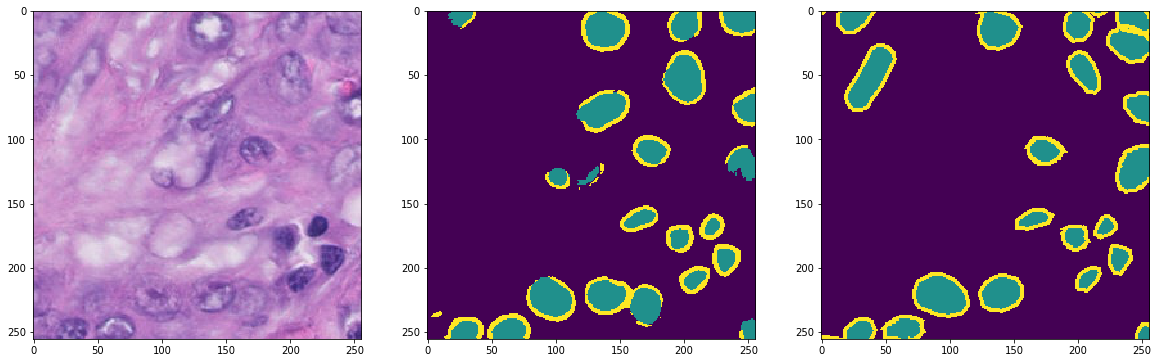

In [40]:
index= 6
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(np.array(i['image_ori'][index]))

plt.subplot(1,3,2)
plt.imshow(output[index]*127)

plt.subplot(1,3,3)
plt.imshow(i['mask'][index])